In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

env: KERAS_BACKEND=tensorflow


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import common

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard

from sklearn import preprocessing
from sklearn import metrics

## Load data

In [6]:
df = common.load_df("../data/insead", "*.csv")

In [7]:
features = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr"]
target = ["cwshdr"]

## Data Preparation

In [8]:
df = common.Process.replace_nulls(df, cols=features+target)
df = common.Process.replace_with_near(df, cols=features+target)
df = common.Process.get_normalized_df(df, cols=features+target)

## Take a sample

In [13]:
# manually select training and validaiton data.
batch_size = 200
train_df = df["2017-01-01":"2017-02"]
validation_df = df["2017-03-01":"2017-03-10"]
lookback = 15

# Prepare features and target vectors
train_x, train_y = common.prepare_keras_data(train_df, features, target, lookback, batch_size)
validation_x, validation_y = common.prepare_keras_data(validation_df, features, target, lookback, batch_size)
print(train_x.shape, train_y.shape)

(84600, 1, 75) (84600, 1, 1)


## Prepare model

In [14]:
model = Sequential([
    LSTM(75, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True, return_sequences=True),
    LSTM(150, stateful=True, return_sequences=True),
    Dense(1)
])

model.compile(
    loss=mean_squared_error,
    optimizer="adam",
    metrics=["accuracy", mean_absolute_percentage_error]
)

## Train model

In [15]:
for epoch in range(150):
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=batch_size,
        verbose=0,
        shuffle=False,
        epochs=1,
        validation_data=(validation_x, validation_y),
        callbacks=[TensorBoard(log_dir="../output/keras3")])
    model.reset_states()
    if epoch % 50 == 0:
        print("At epoch ", epoch)

At epoch  0
At epoch  50
At epoch  100


In [22]:
model.save("../output/cwshdr1.h5")

## Metrics

In [20]:
# Test the validation sample...
predicted_y = model.predict(validation_x, batch_size=batch_size) # predict
predicted_y = common.Reshape.inv_y(predicted_y)
validation_y = common.Reshape.inv_y(validation_y)

# Inverse scale a particular dimension of the dataset.
def inverse_scale(scaler, col, scaler_idx=0):
    col = col.copy()
    col -= scaler.min_[scaler_idx]
    col /= scaler.scale_[scaler_idx]
    return col

idx = list(df.columns).index(target[0])
inv_validation_y = inverse_scale(df.scaler, validation_y, idx)
inv_predicted_y = inverse_scale(df.scaler, predicted_y, idx)

print("MSE: ", metrics.mean_squared_error(validation_y, predicted_y))
print("MAPE: ", common.mean_absolute_percent_error(validation_y, predicted_y))

MSE:  0.000609355128438
MAPE:  4.57579555143


## Forecast

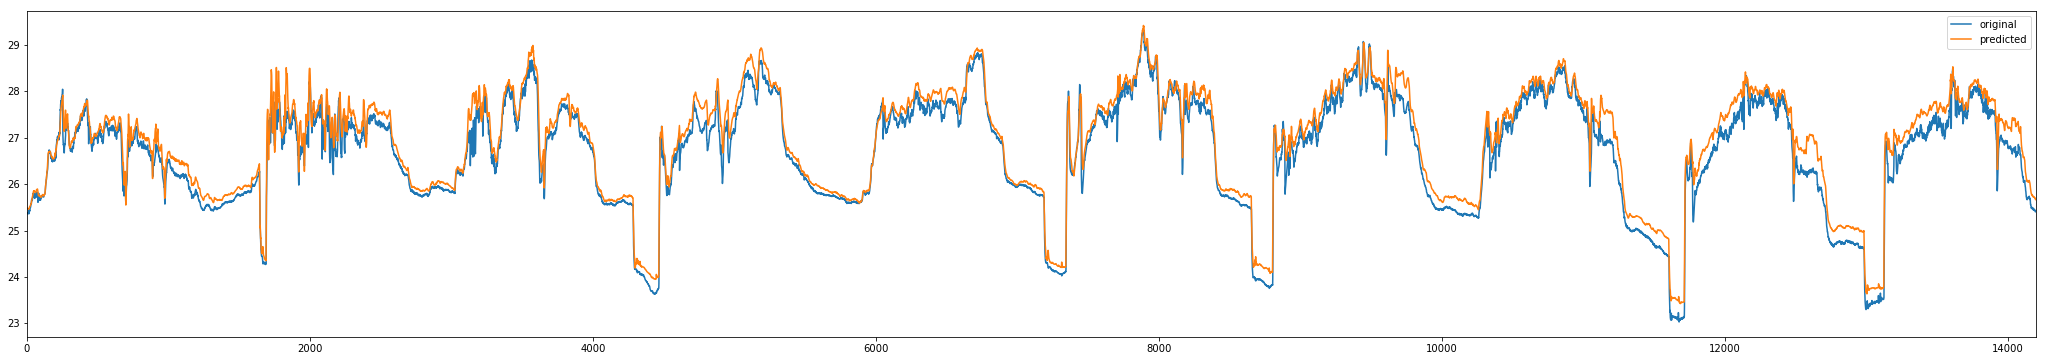

In [21]:
plot_df = pd.DataFrame({"original": inv_validation_y, "predicted": inv_predicted_y})
ax = plot_df.plot(figsize=(36,6))